In [ ]:
import os
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from matplotlib import pyplot as plt
print('setup done')

setup done


In [ ]:
dataset = datasets.MNIST(
    ".",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
)

device = torch.device("cuda:0")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



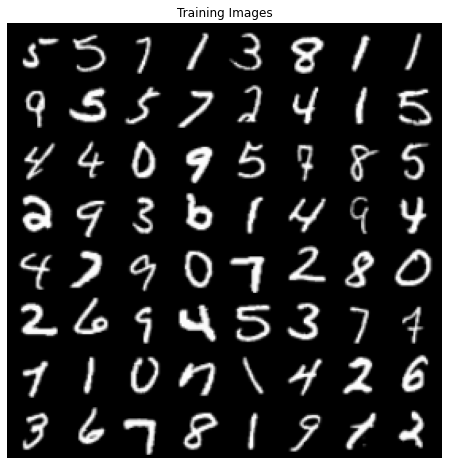

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 8
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 32 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print(generator, end='\n\n')
print(discriminator)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, 

In [ ]:
lr = 0.0002 

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

adversarial_loss = torch.nn.BCELoss()

Tensor = torch.cuda.FloatTensor

In [ ]:
n_epochs = 100
! mkdir images
for epoch in range(n_epochs):

    for i, (imgs, _) in enumerate(dataloader):
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))
        optimizer_G.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        if i % 500 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, 100, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 400 == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/100] [Batch 0/938] [D loss: 0.693300] [G loss: 0.710659]
[Epoch 0/100] [Batch 500/938] [D loss: 0.689997] [G loss: 0.676800]
[Epoch 1/100] [Batch 0/938] [D loss: 0.689456] [G loss: 0.686620]
[Epoch 1/100] [Batch 500/938] [D loss: 0.629640] [G loss: 0.729185]
[Epoch 2/100] [Batch 0/938] [D loss: 0.633863] [G loss: 0.761336]
[Epoch 2/100] [Batch 500/938] [D loss: 0.628100] [G loss: 0.867150]
[Epoch 3/100] [Batch 0/938] [D loss: 0.693047] [G loss: 0.763620]
[Epoch 3/100] [Batch 500/938] [D loss: 0.701097] [G loss: 0.684730]
[Epoch 4/100] [Batch 0/938] [D loss: 0.640350] [G loss: 0.886166]
[Epoch 4/100] [Batch 500/938] [D loss: 0.653769] [G loss: 0.684376]
[Epoch 5/100] [Batch 0/938] [D loss: 0.644845] [G loss: 0.719244]
[Epoch 5/100] [Batch 500/938] [D loss: 0.656553] [G loss: 1.131198]
[Epoch 6/100] [Batch 0/938] [D loss: 0.651605] [G loss: 0.841627]
[Epoch 6/100] [Batch 500/938] [D loss: 0.524072] [G loss: 0.789845]
[Epoch 7/100] [Batch 0/938] [D loss: 0.578626] [G loss: 0.8402

In [ ]:
! mkdir Generated_Images
! mv ./images ./Generated_Images

In [ ]:
dataset = datasets.ImageFolder(root='./Generated_Images/', transform=transforms.Compose(
        [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

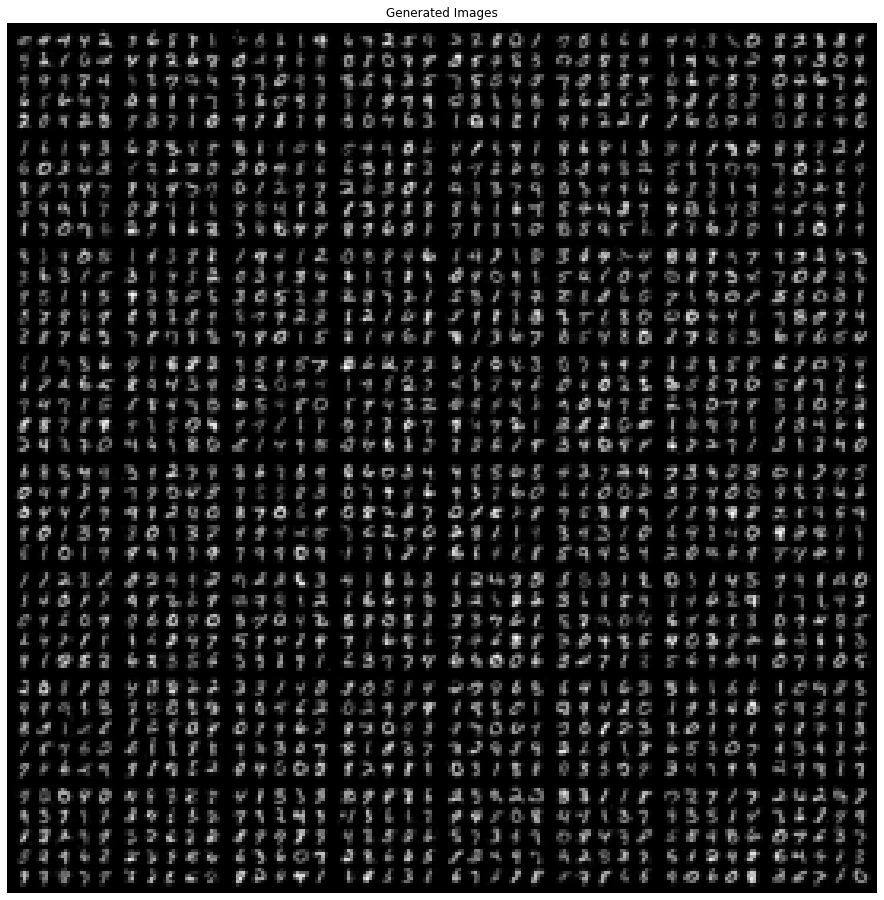

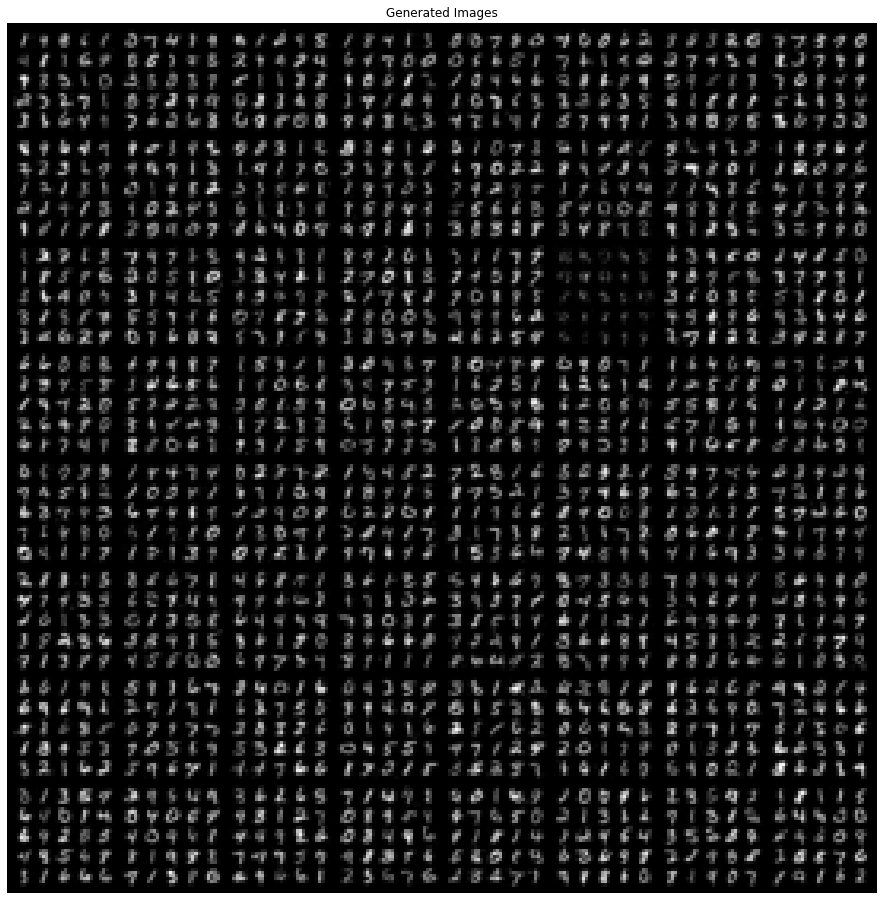

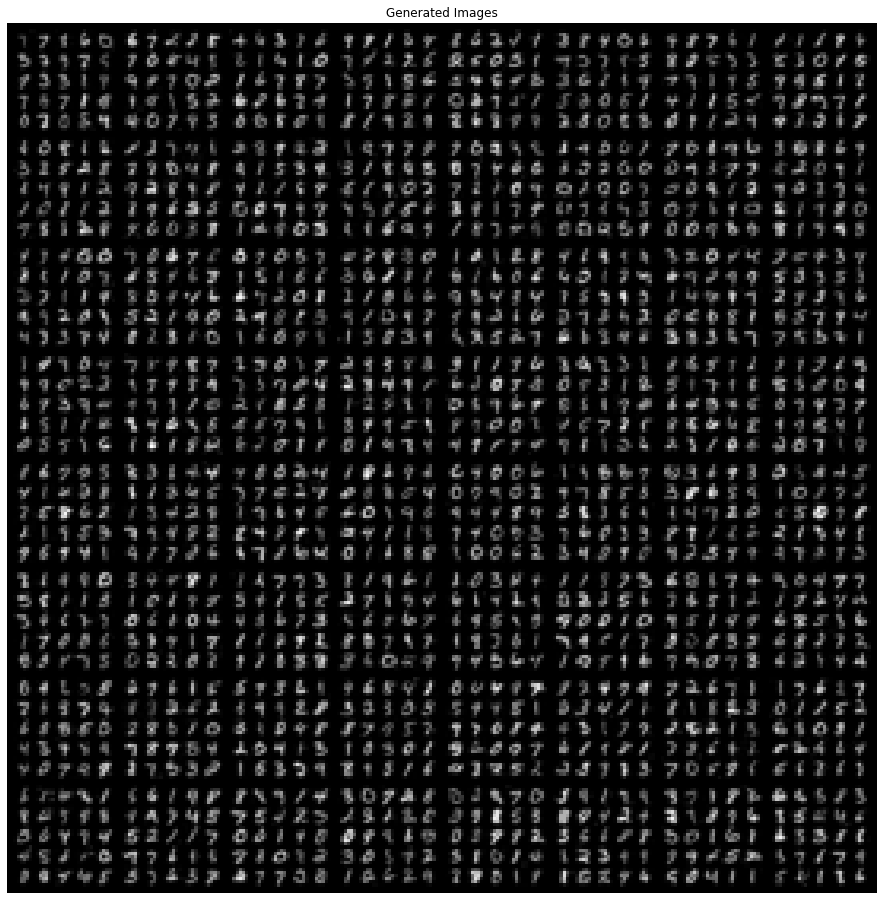

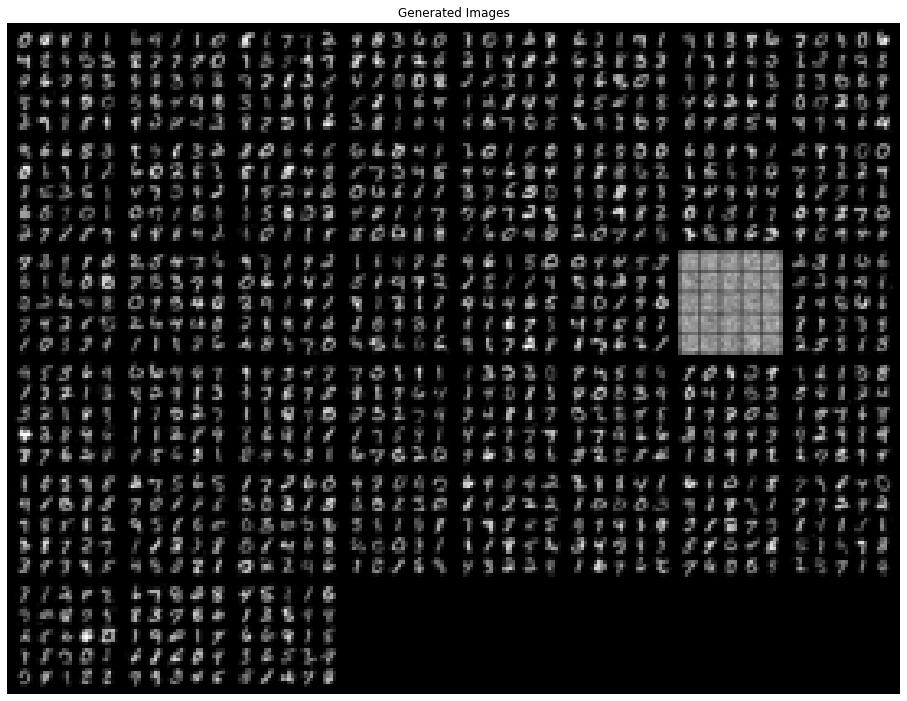

In [ ]:
for i, (imgs, _) in enumerate(dataloader):
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(imgs.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))